<a href="https://colab.research.google.com/github/hamzaraouzi/Pytorch/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Xception</h1>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

<h3>Separable Convolution</h3>

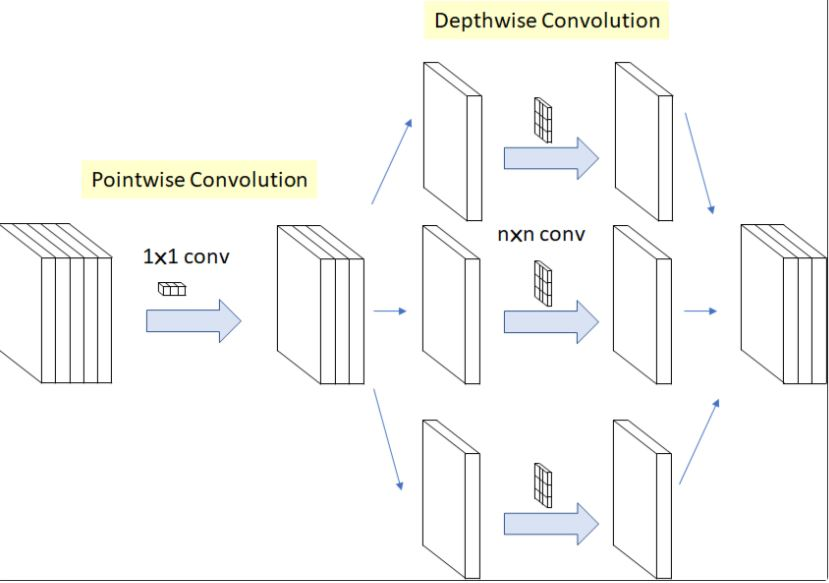

In [ ]:
class Separable(nn.Module):

  def __init__(self,in_channels,out_1x1,out_channels):
    super(Separable,self).__init__()
    self.conv1x1 = nn.Conv2d(in_channels,out_1x1,kernel_size=1,stride=1)
    
    self.depthwise_conv = nn.Conv2d(out_1x1,out_channels,kernel_size=3,stride=1,padding=1,groups=out_1x1)
    

  def forward(self,x):
    x = self.conv1x1(x)
    x = self.depthwise_conv(x)
    return x

In [ ]:
x = torch.rand((5,64,299,299))
model = Separable(64,32,128)
y = model(x)
print(y.shape)

torch.Size([5, 128, 299, 299])


In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels,**kwrags):
    super(conv_block,self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels,out_channels,**kwrags)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

<h3>Entry Flow</h3>

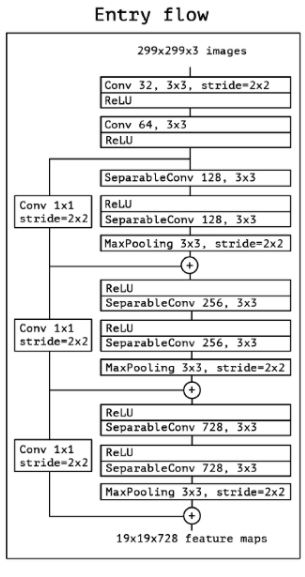

In [ ]:
class EntryFlow(nn.Module):

  def __init__(self,in_channels=3):
    super(EntryFlow,self).__init__()
    self.conv1 = nn.Sequential(
        conv_block(3,32,kernel_size=3,stride=2),
        conv_block(32,64,kernel_size=3,stride=1,padding=1)
    )


    self.res1 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=1,stride=2),
        nn.BatchNorm2d(128)
    )

    self.block1 = nn.Sequential(
        Separable(64,32,128),
        nn.ReLU(),
        Separable(128,64,128),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )

    self.res2 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=1,stride=2),
        nn.BatchNorm2d(256)
    )

    self.block2 = nn.Sequential(
        nn.ReLU(),
        Separable(128,64,256),
        nn.ReLU(),
        Separable(256,128,256),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )
  
    self.res3 = nn.Sequential(
        nn.Conv2d(256,728,kernel_size=1,stride=2),
        nn.BatchNorm2d(728)
    )

    self.block3 = nn.Sequential(
        nn.ReLU(),
        Separable(256,182,728),
        nn.ReLU(),
        Separable(728,364,728),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )

  def forward(self,x):
    x = self.conv1(x)
    x_res = self.res1(x)
    x_block = self.block1(x)
    x = x_res.add(x_block)

    x_res = self.res2(x)
    x_block = self.block2(x)
    x = x_block.add(x_res)

    x_res = self.res3(x)
    x_block = self.block3(x)
    x = x_block.add(x_res)
    return x


In [ ]:
x = torch.rand((5,3,299,299))
model = EntryFlow()
y = model(x)
print(y.shape)

torch.Size([5, 728, 19, 19])


<h3>Middle flow</h3>

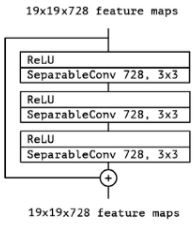

In [ ]:
class MiddleFlow(nn.Module):
  def __init__(self,in_channels=728):
    super(MiddleFlow,self).__init__()
    self.layers = nn.Sequential(
        nn.ReLU(),
        Separable(in_channels,364,in_channels),
        nn.ReLU(),
        Separable(in_channels,364,in_channels),
        nn.ReLU(),
        Separable(in_channels,364,in_channels),
    )

  def forward(self,x):
    return x.add(self.layers(x))

In [ ]:
x = torch.rand((5,728,19,19))
model = MiddleFlow()
y = model(x)
print(y.shape)

torch.Size([5, 728, 19, 19])


<h3>ExitFlow</h3>

<h3></h

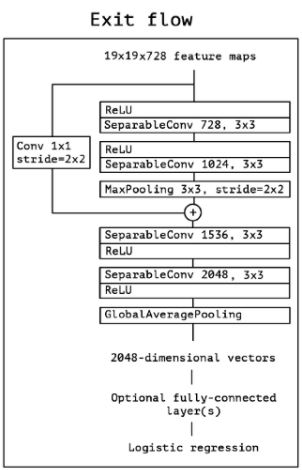

In [ ]:
class ExitFlow(nn.Module):
  def __init__(self,in_channels,num_classes):
    super(ExitFlow,self).__init__()
    self.res = nn.Sequential(
        nn.Conv2d(728,1024,kernel_size=1,stride=2),
        nn.BatchNorm2d(1024)
    )

    self.block = nn.Sequential(
        nn.ReLU(),
        Separable(728,364,728),
        nn.ReLU(),
        Separable(728,512,1024),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )

    self.tail = nn.Sequential(
        Separable(1024,768,1536),
        nn.ReLU(),
        Separable(1536,1024,2048),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(1),
        nn.Linear(2048,1024),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(512,num_classes)
    )

  def forward(self,x):
    x_res =self.res(x)
    x = x_res.add(self.block(x))

    return self.tail(x)


In [ ]:
x = torch.rand((5,728,19,19))
model = ExitFlow(728,10)
y = model(x)
print(y.shape)

torch.Size([5, 10])


<h3>Overall architecture</h3>

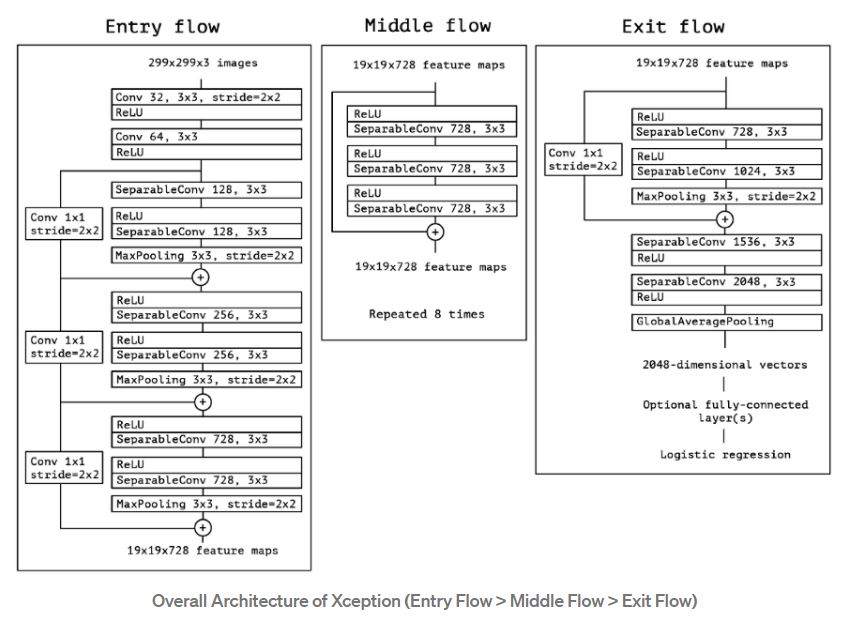

In [ ]:
class Xception(nn.Module):
  def mFlows(self):
    l = []
    for i in range(8):
      l.append(MiddleFlow())

    return nn.Sequential(*l)

  
  def __init__(self,in_channels=3,num_classes=10):
    super(Xception,self).__init__()

    self.entry = EntryFlow()
    
    self.middle_flow = self.mFlows()

    self.exit_flow = ExitFlow(728,num_classes)


  def forward(self,x):
    x = self.entry(x)
    x = self.middle_flow(x)
    x = self.exit_flow(x)

    return x



In [ ]:
x = torch.rand((5,3,299,299))
model = Xception()
y = model(x)
print(y.shape)

torch.Size([5, 10])


<h2>Data Downloading and preproceccing</h2>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp  kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prasunroy/natural-images

natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name="natural-images.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'natural-images/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['airplane/', 'car/', 'cat/', 'dog/', 'flower/','fruit/','motorbike/',
              'person/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [ ]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories


for dir in listdir('natural_images/'):

  for file in listdir('natural_images/'+dir):
    src = 'natural_images/' +dir +'/' +file
    if random() < val_ratio:
      dest = 'natural-images/test/'+ dir +'/'+file
    else:
      dest = 'natural-images/train/'+ dir +'/'+file 

    copyfile(src,dest)

In [ ]:
from torchvision import datasets, transforms
#Applying Transformation
dataset_home = 'natural-images/'
train_transforms = transforms.Compose([
                                transforms.Resize((299,299)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

test_transforms = transforms.Compose([
                                      transforms.Resize((299,299)),
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(dataset_home  + '/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(dataset_home + '/test', 
                                    transform=test_transforms)

#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=32)
testloader = torch.utils.data.DataLoader(test_data,shuffle=True ,batch_size=32)

<h2>images visualization</h2>

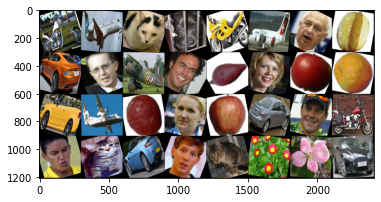

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h2>training function</h2>

<h2></h

In [ ]:
accuracy_list = []

def train(epoch,model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # send to device
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        output = model(data)
        
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


<h2>Test Function</h2>

In [ ]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = model(data)
            #sum up batch loss 
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)

            correct += predicted.eq(target).sum().item()
        
        
        test_loss /= len(testloader.dataset)
        accuracy = 100.*correct/len(testloader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,len(testloader.dataset),
            accuracy
        ))

    return accuracy,test_loss

<h2>Training Loop</h2>

In [ ]:
model.to(device)

PATH ='model.pt'


optimizer = optim.SGD(model.parameters(),momentum=0.9,lr=0.045)

decayRate = 0.94
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)



prev_test_accuracy =-1
for epoch in range(0,100):
  
    model.aux_logits = True
    train(epoch,model)
    model.aux_logits = False
    test_accuracy,test_loss = test(model)

    if epoch%2 == 0:
      lr_scheduler.step()

    if test_accuracy >prev_test_accuracy:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                }, PATH)
        print("weights from epoch {} has been saved ".format(epoch))
        prev_test_accuracy = test_accuracy

<h2>best weights loading</h2>

In [ ]:
loaded_model = Xception()

checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loaded_model.to(device)
loaded_model.eval()
loaded_model.aux_logits= False
test_accuracy,test_loss= test(loaded_model)


Test set: Average loss: 0.0056, Accuracy: 1633/1731 (94%)

